#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.   
**Цель:** построить модель, которая спрогнозирует количество заказов на следующий час.   
**Задачи:**  
1. Загрузить данные, выполнить ресемплирование.
2. Проанализировать данные.
3. Обучить разные модели. 
4. Проверить данные на тестовой выборке и сделать выводы.

# Описание данных

Данные представлены файлом `taxi.csv`.
* datetime - дата и время заказа такси;
* num_orders - количество заказов *целевой признак*

## Загрузка данных, ресемплирование

Загрузка библиотек и констант.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
RANDOM_STATE = 42

pd.set_option('display.max_colwidth', None)

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
display(data.head(5))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные загружены, временной интервал составляет 10 минут. Пропуски не обнаружены.
Данные о количестве заказов представлены с 1 марта 2018 года по 31 августа 2018 года - за пол года.
Проверим последовательность временных интервалов.

In [5]:
data.index.is_monotonic

True

Данные последовательны. Проведем ресемплирование на один час, чтобы сократить интервал.

In [6]:
data = data.resample('1H').sum()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


После ресемплирования осталось 4416 строк.

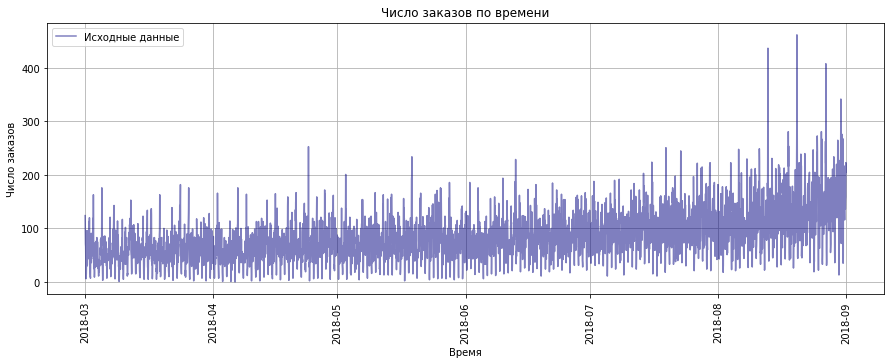

In [8]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=data.index, y=data['num_orders'], label='Исходные данные', alpha=0.5, color='navy')
plt.title('Число заказов по времени')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=90)
plt.legend()

plt.show()

Количество заказов уеличипвается почти в два раза с августа по сентрябрь, скорее всего это связано с окончанием отпусков.

### Промежуточный вывод

**Цель:** загрузить данные и провести ресеплирование.
1. Данные загружены в `data`, объемом в 2 столбца и 26496 строк, пропусков нет.
2. Столбец с датой переведен в индекс, временные отрезки по 10 минут представлены последовательно.
3. Проведено ресемплирование временных отрезков на один час, в `data` осталось 4416 строк.

## Анализ

Построим графики скользящего среднего по суткам и по неделям, чтобы выявить возможные тренды.

In [9]:
data['week'] = data['num_orders'].rolling(168).mean().fillna(0).astype('int')

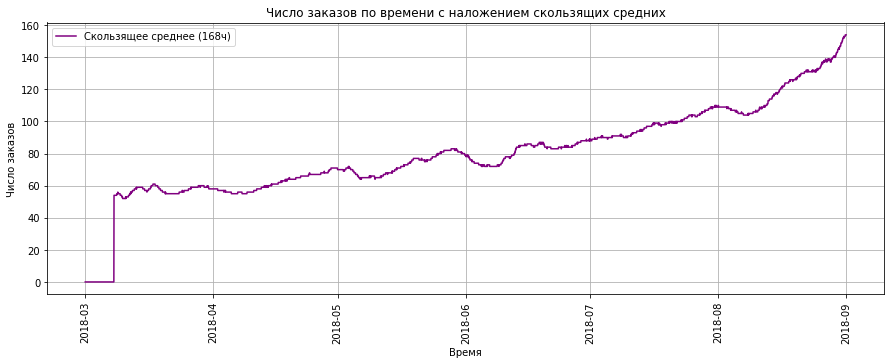

In [10]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=data.index, y=data['week'], label='Скользящее среднее (168ч)', color='purple')
plt.title('Число заказов по времени с наложением скользящих средних')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=90)
plt.legend()

plt.show()

Недельное скользящее среднее явно показывает, что присутсвует общий рост количества заказов , имеются колебания графика внутри недели, рассмотрим их на дневном скользящем тренде. Для сравнения возьмем два среза, один за март, другой за август и сравним.

In [11]:
march = data['2018-03-01':'2018-03-31'].copy()
august = data['2018-08-01':'2018-08-31'].copy()

In [12]:
march['day'] = march['num_orders'].rolling(24).mean()
august['day'] = august['num_orders'].rolling(24).mean()

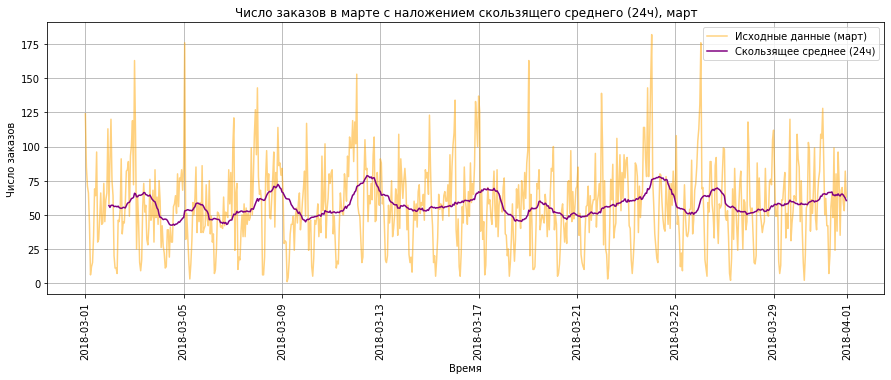

In [13]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=march.index, y=march['num_orders'], label='Исходные данные (март)', alpha=0.5, color='orange')
sns.lineplot(x=march.index, y=march['day'], label='Скользящее среднее (24ч)', color='purple')
plt.title('Число заказов в марте с наложением скользящего среднего (24ч), март')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

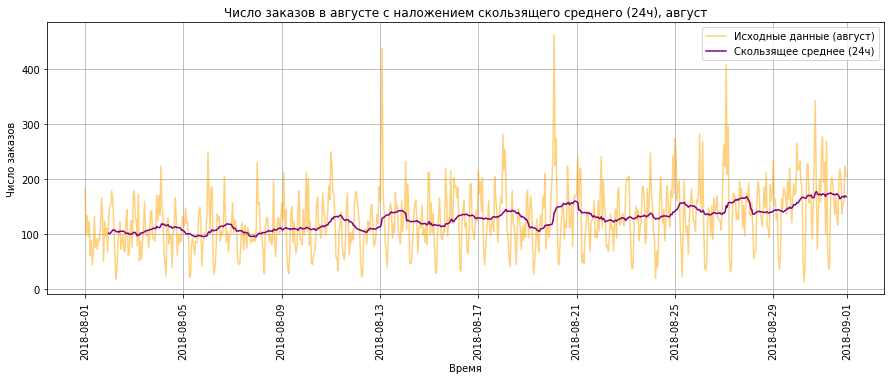

In [14]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=august.index, y=august['num_orders'], label='Исходные данные (август)', alpha=0.5, color='orange')
sns.lineplot(x=august.index, y=august['day'], label='Скользящее среднее (24ч)', color='purple')
plt.title('Число заказов в августе с наложением скользящего среднего (24ч), август')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Во-первых мы видим, что количество максимальных заказов за месяц выросло с марта по август более чем в два раза. С начала по конец марта среднее количество не сильно изменилось, в отличие от августа, где в начале месяца скользящее среднее равялось 100, а в конце приближалось к 180. 

Исследуем тренды и сезонность.

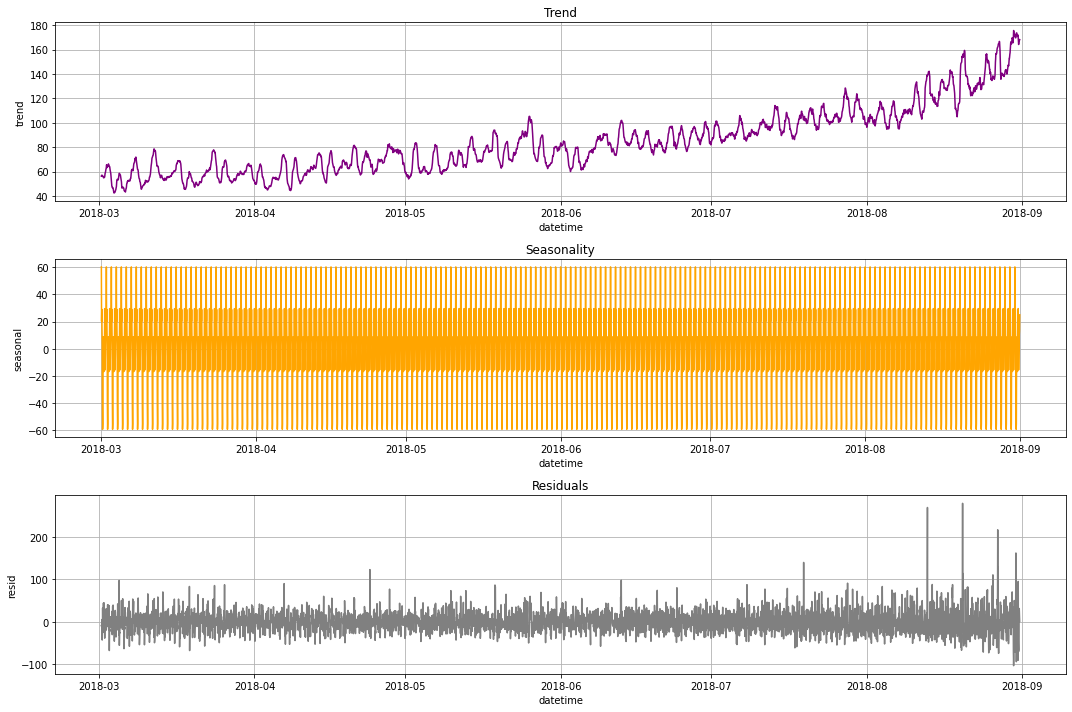

In [15]:
decomposed = seasonal_decompose(data['num_orders'])

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
sns.lineplot(ax=axes[0], x=data.index, y=decomposed.trend, color='purple')
axes[0].set_title('Trend')
axes[0].grid(True)

sns.lineplot(ax=axes[1], x=data.index, y=decomposed.seasonal, color='orange')
axes[1].set_title('Seasonality')
axes[1].grid(True)

sns.lineplot(ax=axes[2], x=data.index, y=decomposed.resid, color='gray')
axes[2].set_title('Residuals')
axes[2].grid(True)

plt.tight_layout()
plt.show()

Приблизим сезонность.

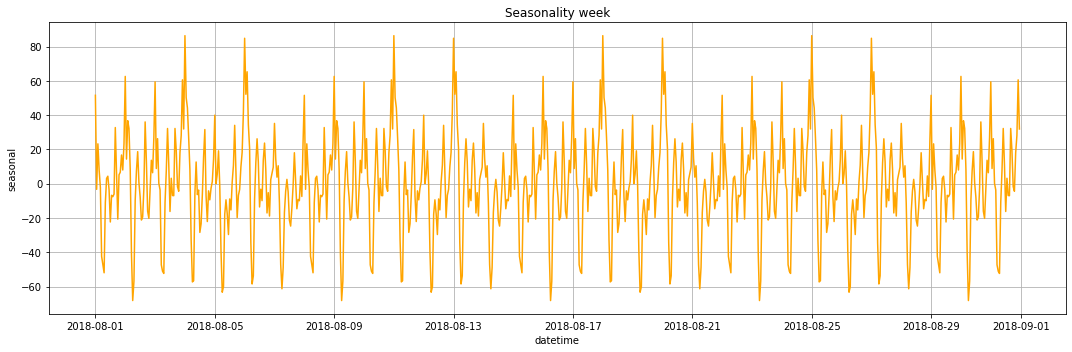

In [16]:
decomposed_week = seasonal_decompose(data['num_orders'], period=168)
seasonality = decomposed_week.seasonal
seasonality_august = seasonality['2018-08-01':'2018-08-31']

plt.figure(figsize=(15, 5))
sns.lineplot(x=seasonality_august.index, y=seasonality_august, color='orange')
plt.title('Seasonality week')
plt.grid(True)

plt.tight_layout()
plt.show()

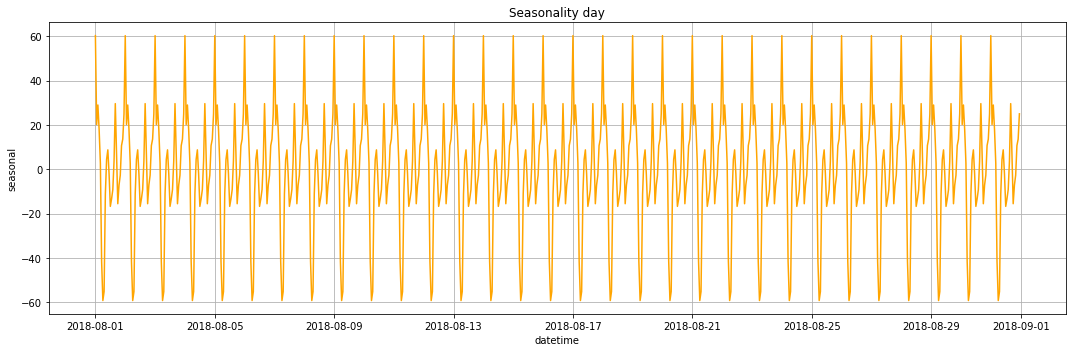

In [17]:
decomposed_week = seasonal_decompose(data['num_orders'], period=24)
seasonality = decomposed_week.seasonal
seasonality_august = seasonality['2018-08-01':'2018-08-31']

plt.figure(figsize=(15, 5))
sns.lineplot(x=seasonality_august.index, y=seasonality_august, color='orange')
plt.title('Seasonality day')
plt.grid(True)

plt.tight_layout()
plt.show()

Наблюдается ожидаемая сезонность: 
    - видны два пика в недельной сезонности, где количество заказов превышает 80, скорее всего это выходные дни;
    - видны пики в 60 заказов в резким последующим отрицательным спадом в дневной сезонности, скорее всего это перемена дня и ночи.

Создадим признаки. Сдвинем данные на 1, 24 и 128 часов, так же добавим скользящее среднее за сутки и неделю и признаки времени: час, день недели, выходной день или нет. 

In [18]:
data['day'] = data['num_orders'].rolling(24).mean().fillna(0).astype('int')

data['lag_1'] = data['num_orders'].shift(1).fillna(0).astype('int')
data['lag_24'] = data['num_orders'].shift(24).fillna(0).astype('int')
data['lag_168'] = data['num_orders'].shift(168).fillna(0).astype('int')

data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['is_weekend'] = data['dayofweek'].apply(lambda x: 0 if x >= 5 else 1)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   week        4416 non-null   int64
 2   day         4416 non-null   int64
 3   lag_1       4416 non-null   int64
 4   lag_24      4416 non-null   int64
 5   lag_168     4416 non-null   int64
 6   hour        4416 non-null   int64
 7   dayofweek   4416 non-null   int64
 8   is_weekend  4416 non-null   int64
dtypes: int64(9)
memory usage: 474.0 KB


In [20]:
data.head()

,num_orders,week,day,lag_1,lag_24,lag_168,hour,dayofweek,is_weekend
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,0,0,0,0,0,3,1
2018-03-01 01:00:00,85,0,0,124,0,0,1,3,1
2018-03-01 02:00:00,71,0,0,85,0,0,2,3,1
2018-03-01 03:00:00,66,0,0,71,0,0,3,3,1
2018-03-01 04:00:00,43,0,0,66,0,0,4,3,1


Данные корректы, не имеют пропусков.

Исследуем целевой признак.

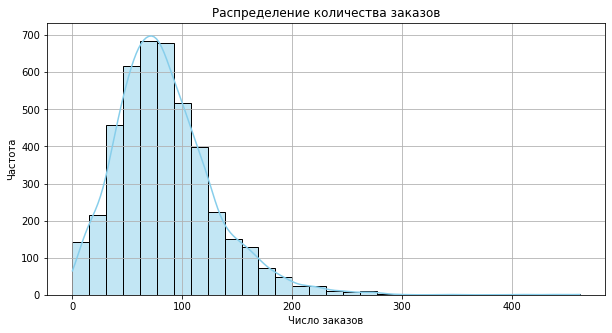

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(data['num_orders'], bins=30, kde=True, color='skyblue')
plt.title('Распределение количества заказов')
plt.xlabel('Число заказов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

data['num_orders'].describe()

Основная масса заказов варируется от 50 до 110 штук. График имеет длинный правый хвост, свидетельсвующий о том, что количество заказов бывает экстремально высоким (до 462 штук), но такие заказы редки.

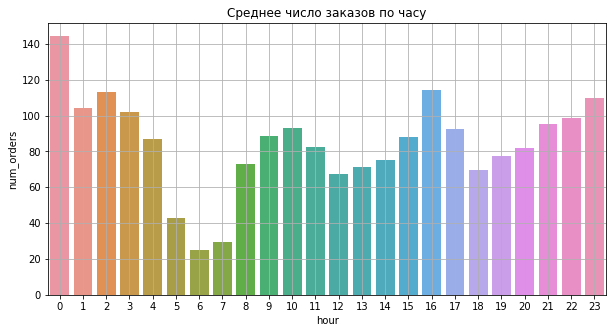

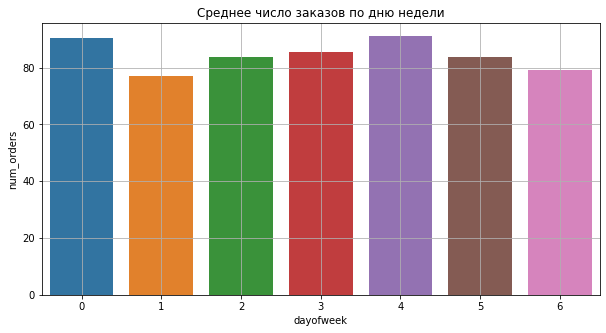

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x='hour', y='num_orders', data=data.groupby('hour')['num_orders'].mean().reset_index())
plt.title('Среднее число заказов по часу')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='dayofweek', y='num_orders', data=data.groupby('dayofweek')['num_orders'].mean().reset_index())
plt.title('Среднее число заказов по дню недели')
plt.grid(True)
plt.show()

Набольшее количество заказов в 16 часов и с 23 до 3 утра. Наименьшее число заказов с 5 до 7 утра. Самые популярные дни недели  - понедельник и пятница, самый непопулярный - вторник. Разброс в заказах по дням недели мал.

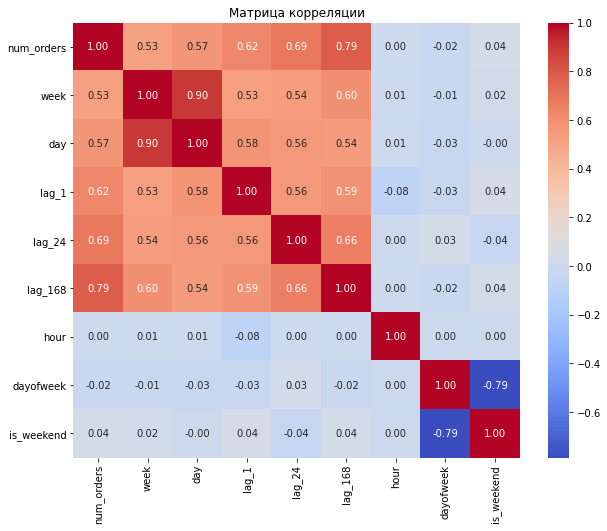

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

С целевым признаком признаки lag_128, lag_24 имеют сильную положительную зависимость. Признаки week, day, lag_1 имеют умеренную положительную зависимость. Мультиколлинеарность отсутсвует.

### Промежуточный вывод

**Цель:** провести исследоваательский анализ данных.
1. Тренд на рост количества заказов растёт от марта к августу, увеличившись более чем в 2 раза.
2. Иммется недельная и суточная сезонность - в вечерне-ночное время много заказов, в расветные часы мало, так же в понедельник и четверг много заказовю
3. Добавлены новые признаки `week`, `day`, `lag_1`, `lag_24`, `lag_128`, `hour`, `dayofweek`, `is_weekend`.
4. Признаки лагов (lag_24, lag_168) показывают сильную корреляцию с целевым признаком. Мультиколлинеарность отсутствует.

## Обучение

Перед нами задача регрессии временных рядов, с горизонтом прогнозирования в 1 час.    
Разделим данные на тренировочную и тестовую выборки с соотношением 9:1.

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные разделились корректно, последовательно.

In [25]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Обучим модели RandomForestRegressor, KNeighborsRegressor, LGBMRegressor, XGBRegressor так же модели линейной ргерессии с регуляризациями. Для подбора гиперпараметров используем GridSearchCV.

In [26]:
num_features = ['week', 'day', 'lag_1', 'lag_24', 'lag_168', 'hour', 'dayofweek']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features)
], remainder='passthrough') 

models = {
    'Baseline_LinearRegression': {
        'model': LinearRegression(),
        'params': {} 
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__metric': ['euclidean', 'manhattan']
        }
    },
    'LGBM': {
        'model': LGBMRegressor(random_state=RANDOM_STATE),
        'params': {
            'model__num_leaves': [31, 50],
            'model__n_estimators': [100, 200]
        }
    },
    'XGB': {
        'model': XGBRegressor(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 6]
        }
    },
    'Ridge': {
        'model': Ridge(random_state=RANDOM_STATE),
        'params': {
            'model__alpha': [0.1, 1.0, 10.0],
            'model__solver': ['auto', 'saga']
        }
    },
    'Lasso': {
        'model': Lasso(random_state=RANDOM_STATE, max_iter=10000),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=RANDOM_STATE, max_iter=10000),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0],
            'model__l1_ratio': [0.1, 0.5, 0.9]
        }
    }
}

### Промежуточный вывод

**Цель:** определить модели и обучить.
1. Тренирорвочная и тестовая выборка поделены в соотношении 9:1.
2. Baseline модель - Линейная регрессия.
3. Создан пайплайн включающий в себя препроцессор сo Standart Scaler для масштабирования признаков и моделями RandomForestRegressor, KNeighborsRegressor, LGBMRegressor, XGBRegressor, Ridge, Lasso, ElasticNet.

## Тестирование

In [27]:
best_models = {}
results = []

for name, cfg in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', cfg['model'])])
    grid = GridSearchCV(pipe, cfg['params'], cv=TimeSeriesSplit(n_splits=3), scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_

    params = grid.best_estimator_.get_params()
    best_cv_score = -grid.best_score_
    model_params = {k.replace('model__', ''): v for k, v in params.items() if k.startswith('model__')}
    
    results.append({
        'Model': name,
        'CV_RMSE': round(best_cv_score, 2),
        'Best Params': model_params
    })

results_df = pd.DataFrame(results).sort_values(by='CV_RMSE').reset_index(drop=True)

In [28]:
results_df

,Model,CV_RMSE,Best Params
0,LGBM,23.45,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}"
1,RandomForest,23.51,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"
2,Baseline_LinearRegression,23.97,"{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}"
3,Ridge,23.97,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': 42, 'solver': 'saga', 'tol': 0.001}"
4,Lasso,23.97,"{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}"
5,ElasticNet,23.97,"{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}"
6,KNN,24.43,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}"
7,XGB,25.16,"{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}"


Лучшей моделью является модель LGBM	 со стандартными настройками, итерацией бустинга 100, макимумом листьев 31 и шагом 0.1, значение **CV_RMSE: 23.45**

In [29]:
final_model = best_models['Ridge']
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

predictions_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred
})

In [30]:
final_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Final RMSE on Test: {final_rmse:.2f}')

Final RMSE on Test: 35.38


У лучшей модели метрика на тестовой выборке **RMSE: 35.38**.

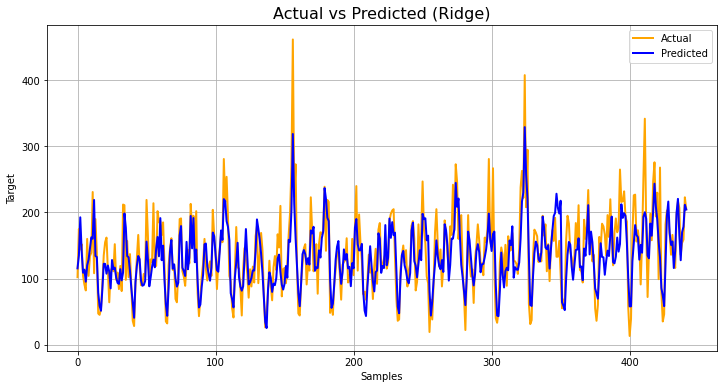

In [31]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=predictions_df['Actual'], label='Actual', color='orange', linewidth=2)
sns.lineplot(data=predictions_df['Predicted'], label='Predicted', color='blue', linewidth=2)
plt.title(f'Actual vs Predicted (Ridge)', fontsize=16)
plt.xlabel('Samples')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

Модель боится предсказывать самые низкие и высокие значения, осторожничает.

### Промежуточный вывод

**Цель:** протестировать модель.
1. С помощью GridSearchCV подобраны гиперпараметры моделей и по метрике RMSE определена лучшая модель.
2. Лучшая модель это модель LGBM со стандартными настройками, итерацией бустинга 100, макимумом листьев 31 и шагом 0.1, значение RMSE на тестовой выборке 35.38.
3. Модель хорошо учитывает линейные зависимости.

# Общий вывод

В рамках проекта был проведён полный цикл построения модели прогнозирования количества заказов такси по часовым интервалам. На этапе подготовки данные были успешно загружены и агрегированы с 10-минутных интервалов до часовых, что позволило получить 4416 наблюдений без пропусков. Исследовательский анализ выявил ярко выраженную сезонность в данных: суточные колебания с пиками в вечернее и ночное время, а также недельную цикличность с максимальными значениями заказов по понедельникам и четвергам. Были созданы новые признаки (лаги, день недели, часы), усиливающие модельные зависимости.

Для решения задачи были построены и протестированы несколько моделей: от простого baseline в виде линейной регрессии до ансамблевых алгоритмов (RandomForest, XGBoost, LGBM) и регуляризованных линейных моделей (Ridge, Lasso, ElasticNet). Лучшей оказалась  LGBM со стандартными настройками, итерацией бустинга 100, макимумом листьев 31 и шагом 0.1, показавшая на тестовой выборке метрику **RMSE=35.38**.

Модель эффективно улавливает линейные зависимости и учитывает краткосрочные и долгосрочные тренды через лаговые признаки, однако склонна занижать предсказания на экстремальных значениях (низкие и высокие пики спроса), что типично для линейных моделей. Таким образом, для задачи краткосрочного прогнозирования количества заказов в аэропортах модель LGBM показала себя как надёжный и интерпретируемый инструмент с минимальной ошибкой в пределах допустимого уровня.